<a href="https://colab.research.google.com/github/kngan79/learn-data-science/blob/master/index2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import re

%matplotlib inline
%load_ext google.colab.data_table

In [ ]:
DATA = "https://raw.githubusercontent.com/tiwari91/Housing-Prices/master/train.csv"

In [ ]:
df = pd.read_csv(DATA)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
pd.get_dummies(df,drop_first=True) #drop để giảm số lượng biến và tránh đa cộng tuyến

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,...,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500,0,0,...,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500,0,0,...,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000,0,0,...,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000,0,0,...,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,175000,0,0,...,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,210000,0,0,...,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,266500,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,142125,0,0,...,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
pd.get_dummies(df,drop_first=True).columns.tolist()

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 '

In [ ]:
def prepare_data(data_path):
    house_prices = pd.read_csv(data_path)
    house_prices = house_prices.drop(columns='Id')
    numerical_columns = house_prices.drop(columns='SalePrice').select_dtypes('number').columns #bo di var can predict va lay data co type la number
    non_numerical_columns = house_prices.select_dtypes(['category', 'object']).columns

    # Missing data filling
    house_prices[numerical_columns] = house_prices[numerical_columns].fillna('mean')
    house_prices[non_numerical_columns] = house_prices[non_numerical_columns].fillna('missing')

    # Outliers removing
    z_SalePrice = zscore(house_prices.SalePrice)
    z_gt_2 = z_SalePrice > 2 #thuong chon z la 2 hoac 3
    house_prices = house_prices.drop(index=house_prices[z_gt_2].index)
    print('The number of outliers:', len(z_gt_2))

    # Highly correlated variable removing
    corr_matrix = house_prices.drop(columns='SalePrice').corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) #lay phan matrix duong vi phan matrix duoi doi xung vs phan tren
    to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
    print('Highly correlated variables to drop:', to_drop)
    house_prices = house_prices.drop(columns=to_drop)

    # One-hot encoding
    house_prices = pd.get_dummies(house_prices)

    new_columns = []
    for i in house_prices.columns:
        new_name = re.sub(r'\W+', '_', i)
        if re.match('^\d', new_name):
            new_name = '_' + new_name
        new_columns.append(new_name)
    house_prices.columns = new_columns

    print('Final data shape:', house_prices.shape)

    return house_prices

In [ ]:
house_prices = prepare_data(DATA)

The number of outliers: 1460
Highly correlated variables to drop: ['TotRmsAbvGrd', 'GarageArea']
Final data shape: (1397, 803)


# Linear Regression with `statmodels`

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
results = smf.ols('SalePrice ~ OverallQual + LotArea', data=house_prices).fit()

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     1309.
Date:                Mon, 11 Jan 2021   Prob (F-statistic):          9.43e-321
Time:                        07:10:41   Log-Likelihood:                -16588.
No. Observations:                1397   AIC:                         3.318e+04
Df Residuals:                    1394   BIC:                         3.320e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.596e+04   4519.028    -12.383      

## Feature importance (feature selection)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

X = house_prices.drop(columns='SalePrice') #tat ca bien doc lap
Y = house_prices.SalePrice #bien phu thuoc
names = X.columns
rf = RandomForestRegressor()
rf.fit(X, Y)

feature_importance = pd.DataFrame(
    {
        'names': names,
        'feature_importance': rf.feature_importances_
    }
)

In [ ]:
sorted_fi = feature_importance.sort_values(by="feature_importance", ascending=False)
top_fi = sorted_fi.head(20).names.tolist()
sorted_fi.head(10)

,names,feature_importance
2,OverallQual,0.550579
13,GrLivArea,0.144194
9,TotalBsmtSF,0.066209
6,BsmtFinSF1,0.022842
1,LotArea,0.018691
10,_1stFlrSF,0.015837
4,YearBuilt,0.014684
21,GarageCars,0.014678
5,YearRemodAdd,0.009681
3,OverallCond,0.007367


In [ ]:
subset_house_price = house_prices[top_fi + ['SalePrice']] #chi gom nhung bien da lay ra
subset_house_price.head()

,OverallQual,GrLivArea,TotalBsmtSF,BsmtFinSF1,LotArea,_1stFlrSF,YearBuilt,GarageCars,YearRemodAdd,OverallCond,_2ndFlrSF,BsmtUnfSF,OpenPorchSF,WoodDeckSF,GarageType_Detchd,BsmtQual_Gd,MSZoning_RM,LotShape_Reg,CentralAir_N,MoSold,SalePrice
0,7,1710,856,706,8450,856,2003,2,2003,5,854,150,61,0,0,1,0,1,0,2,208500
1,6,1262,1262,978,9600,1262,1976,2,1976,8,0,284,0,298,0,1,0,1,0,5,181500
2,7,1786,920,486,11250,920,2001,2,2002,5,866,434,42,0,0,1,0,0,0,9,223500
3,7,1717,756,216,9550,961,1915,3,1970,5,756,540,35,0,1,0,0,0,0,2,140000
4,8,2198,1145,655,14260,1145,2000,3,2000,5,1053,490,84,192,0,1,0,0,0,12,250000


## Forward Selection
Credit: https://planspace.org/20150423-forward_selection_with_statsmodels/

In [ ]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
best_model = forward_selected(subset_house_price, "SalePrice")

In [ ]:
print(best_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     391.1
Date:                Mon, 11 Jan 2021   Prob (F-statistic):               0.00
Time:                        07:10:50   Log-Likelihood:                -16168.
No. Observations:                1397   AIC:                         3.237e+04
Df Residuals:                    1381   BIC:                         3.245e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -9.69e+05   9.95e+0

# Classification

In [ ]:
CHURN = "https://github.com/pnhuy/datasets/raw/master/Churn.xls"

In [ ]:
df= pd.read_excel(CHURN)
df.head()

,Account Length,VMail Message,Day Mins,Eve Mins,Night Mins,Intl Mins,CustServ Calls,Churn,Int'l Plan,VMail Plan,Day Calls,Day Charge,Eve Calls,Eve Charge,Night Calls,Night Charge,Intl Calls,Intl Charge,State,Area Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [ ]:
def get_churn_data(path):
    churn = pd.read_excel(CHURN)
    churn.drop(columns='Phone', inplace=True)
    
    # Process columns name
    new_columns = []
    for i in churn.columns:
        new_name = re.sub(r'\W+', '_', i)
        if re.match('^\d', new_name):
            new_name = '_' + new_name
        new_columns.append(new_name)
    churn.columns = new_columns
    churn = pd.get_dummies(churn)
    return churn

In [ ]:
#@title Default title text
churn = get_churn_data(CHURN)
churn.head()

,Account_Length,VMail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Int_l_Plan,VMail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Area_Code,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,27.47,103,16.62,103,11.45,3,3.70,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,50.90,88,5.26,89,8.86,7,1.78,408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,28.34,122,12.61,121,8.41,3,2.73,415,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


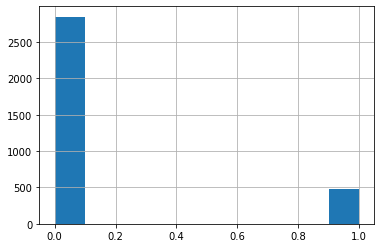

In [ ]:
churn.Churn.hist()

## Feature selection

In [ ]:
X = churn.drop(columns='Churn')
Y = churn.Churn
names = X.columns
rf = RandomForestClassifier()
rf.fit(X, Y)

feature_importance = pd.DataFrame(
    {
        'names': names,
        'feature_importance': rf.feature_importances_
    }
)

sorted_fi = feature_importance.sort_values(by="feature_importance", ascending=False)
top_fi = sorted_fi.head(10).names.tolist()
sorted_fi.head(10)

,names,feature_importance
2,Day_Mins,0.135256
10,Day_Charge,0.129210
6,CustServ_Calls,0.103528
7,Int_l_Plan,0.066345
12,Eve_Charge,0.058041
3,Eve_Mins,0.054317
15,Intl_Calls,0.041958
16,Intl_Charge,0.039913
5,Intl_Mins,0.039277
4,Night_Mins,0.036991


In [ ]:
subset_churn = churn[top_fi + ["Churn"]]
subset_churn.head()

,Day_Mins,Day_Charge,CustServ_Calls,Int_l_Plan,Eve_Charge,Eve_Mins,Intl_Calls,Intl_Charge,Intl_Mins,Night_Mins,Churn
0,265.1,45.07,1,0,16.78,197.4,3,2.70,10.0,244.7,0
1,161.6,27.47,1,0,16.62,195.5,3,3.70,13.7,254.4,0
2,243.4,41.38,0,0,10.30,121.2,5,3.29,12.2,162.6,0
3,299.4,50.90,2,1,5.26,61.9,7,1.78,6.6,196.9,0
4,166.7,28.34,3,1,12.61,148.3,3,2.73,10.1,186.9,0


In [ ]:
subset_churn.shape

(3333, 11)

In [ ]:
churn_train = subset_churn[0:2222]
churn_test = subset_churn[2222:]
print(churn_train.shape)
print(churn_test.shape)

(2222, 11)
(1111, 11)


In [ ]:
from sklearn.model_selection import train_test_split

churn_train, churn_test = train_test_split(subset_churn, test_size = 0.3)

In [ ]:
churn_train.shape

(2333, 11)

In [ ]:
churn_test.shape

(1000, 11)

## Logistic Regression

In [ ]:
subset_churn

,Day_Mins,Day_Charge,CustServ_Calls,Int_l_Plan,Eve_Charge,Eve_Mins,Intl_Calls,Intl_Charge,Intl_Mins,Night_Mins,Churn
0,265.1,45.07,1,0,16.78,197.4,3,2.70,10.0,244.7,0
1,161.6,27.47,1,0,16.62,195.5,3,3.70,13.7,254.4,0
2,243.4,41.38,0,0,10.30,121.2,5,3.29,12.2,162.6,0
3,299.4,50.90,2,1,5.26,61.9,7,1.78,6.6,196.9,0
4,166.7,28.34,3,1,12.61,148.3,3,2.73,10.1,186.9,0
...,...,...,...,...,...,...,...,...,...,...,...
3328,156.2,26.55,2,0,18.32,215.5,6,2.67,9.9,279.1,0
3329,231.1,39.29,3,0,13.04,153.4,4,2.59,9.6,191.3,0
3330,180.8,30.74,2,0,24.55,288.8,6,3.81,14.1,191.9,0
3331,213.8,36.35,2,1,13.57,159.6,10,1.35,5.0,139.2,0


In [ ]:
' '.join(subset_churn.drop(columns='Churn').columns.tolist())

'Day_Mins Day_Charge CustServ_Calls Int_l_Plan Eve_Charge Eve_Mins Intl_Calls Intl_Charge Intl_Mins Night_Mins'

In [ ]:
formula = "Churn ~ " + " + ".join(subset_churn.drop(columns='Churn').columns)
print(formula)

Churn ~ Day_Mins + Day_Charge + CustServ_Calls + Int_l_Plan + Eve_Charge + Eve_Mins + Intl_Calls + Intl_Charge + Intl_Mins + Night_Mins


In [ ]:
  logreg = smf.logit(formula, data=churn_train).fit()

Optimization terminated successfully.
         Current function value: 0.334853
         Iterations 7


In [ ]:
print(logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2333
Model:                          Logit   Df Residuals:                     2322
Method:                           MLE   Df Model:                           10
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.1965
Time:                        07:10:53   Log-Likelihood:                -781.21
converged:                       True   LL-Null:                       -972.28
Covariance Type:            nonrobust   LLR p-value:                 5.924e-76
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.4229      0.595    -12.476      0.000      -8.589      -6.257
Day_Mins          -0.7067      3.871     -0.183      0.855      -8.294       6.881
Day_Charge         4.2275     22.772

In [ ]:
 logreg = smf.logit("Churn ~ CustServ_Calls + Int_l_Plan + Intl_Calls + Night_Mins", data=churn_train).fit()

Optimization terminated successfully.
         Current function value: 0.361397
         Iterations 6


In [ ]:
print(logreg.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 2333
Model:                          Logit   Df Residuals:                     2328
Method:                           MLE   Df Model:                            4
Date:                Mon, 11 Jan 2021   Pseudo R-squ.:                  0.1328
Time:                        07:10:54   Log-Likelihood:                -843.14
converged:                       True   LL-Null:                       -972.28
Covariance Type:            nonrobust   LLR p-value:                 1.066e-54
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.0350      0.313     -9.683      0.000      -3.649      -2.421
CustServ_Calls     0.4455      0.043     10.396      0.000       0.362       0.529
Int_l_Plan         2.0246      0.161

In [ ]:
new_data = pd.DataFrame(
    {
        'CustServ_Calls': [1,0],
        'Int_l_Plan': [1,0],
        'Intl_Calls':[5,0],
        'Night_Mins':[100,200]
    }
)
new_data

,CustServ_Calls,Int_l_Plan,Intl_Calls,Night_Mins
0,1,1,5,100
1,0,0,0,200


In [ ]:
logreg.predict(new_data)

0    0.314992
1    0.077087
dtype: float64

In [ ]:
pred_proba = logreg.predict(churn_test)
pred_label = (pred_proba > 0.5).astype('int')
pred_label

3274    0
3087    0
2260    0
1290    0
2445    0
       ..
836     0
2328    0
1648    0
444     1
702     0
Length: 1000, dtype: int64

In [ ]:
pred_label.sum()

31

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('Accuracy:', accuracy_score(churn_test.Churn, pred_label))
print('Precision:', precision_score(churn_test.Churn, pred_label))
print('Recall:', recall_score(churn_test.Churn, pred_label))
print('F1-score:', f1_score(churn_test.Churn, pred_label))
print('AUC:', roc_auc_score(churn_test.Churn, pred_proba))

Accuracy: 0.854
Precision: 0.41935483870967744
Recall: 0.09219858156028368
F1-score: 0.1511627906976744
AUC: 0.7036633393604637


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train = churn_train.drop(columns='Churn')
y_train = churn_train.Churn

X_test = churn_test.drop(columns='Churn')
y_test = churn_test.Churn

In [ ]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred_proba = rf.predict_proba(X_test)[:, 1]
pred_label = rf.predict(X_test)

In [ ]:
print('Accuracy:', accuracy_score(churn_test.Churn, pred_label))
print('Precision:', precision_score(churn_test.Churn, pred_label))
print('Recall:', recall_score(churn_test.Churn, pred_label))
print('F1-score:', f1_score(churn_test.Churn, pred_label))
print('AUC:', roc_auc_score(churn_test.Churn, pred_proba))

Accuracy: 0.938
Precision: 0.8761904761904762
Recall: 0.6524822695035462
F1-score: 0.7479674796747967
AUC: 0.9273854638826278


##GridSearch


In [ ]:
from sklearn.model_selection import GridSearchCV #cross validation

params = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5 ,7, 9]
}

rf = RandomForestClassifier()

grid = GridSearchCV(rf,params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
grid.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [ ]:
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred_proba = best_rf.predict_proba(X_test)[:, 1]
pred_label = best_rf.predict(X_test)

print('Accuracy:', accuracy_score(churn_test.Churn, pred_label))
print('Precision:', precision_score(churn_test.Churn, pred_label))
print('Recall:', recall_score(churn_test.Churn, pred_label))
print('F1-score:', f1_score(churn_test.Churn, pred_label))
print('AUC:', roc_auc_score(churn_test.Churn, pred_proba))

Accuracy: 0.935
Precision: 0.8584905660377359
Recall: 0.6453900709219859
F1-score: 0.736842105263158
AUC: 0.9279386388593037


# Hypo test

In [ ]:
full_churn = pd.read_excel(CHURN)

# Process columns name
new_columns = []
for i in full_churn.columns:
    new_name = re.sub(r'\W+', '_', i)
    if re.match('^\d', new_name):
        new_name = '_' + new_name
    new_columns.append(new_name)
full_churn.columns = new_columns

In [ ]:
churn_0 = full_churn[full_churn.Churn == 0]
churn_1 = full_churn[full_churn.Churn == 1]

In [ ]:
churn_0.head()

,Account_Length,VMail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Int_l_Plan,VMail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,0,0,1,110,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,0,0,1,123,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,0,1,0,71,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,0,1,0,113,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [ ]:
# T-test

In [ ]:
from statsmodels.stats.weightstats import ttest_ind

In [ ]:
ttest_ind(churn_0['CustServ_Calls'], churn_1['CustServ_Calls']) # return (t-stat, p-value, df)

(-12.319375496769155, 3.900360240189228e-34, 3331.0)

In [ ]:
# ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [ ]:
model = ols('CustServ_Calls ~ C(State)', data=full_churn).fit()

In [ ]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(State),50.0,83.410824,1.668216,0.963471,0.547013
Residual,3282.0,5682.670784,1.731466,NaN,NaN


# Read more

* More examples in `statsmodels`: https://www.statsmodels.org/stable/examples/index.html
* Ridge/Lasso:
    * https://www.geeksforgeeks.org/implementation-of-lasso-ridge-and-elastic-net/
    * http://ethen8181.github.io/machine-learning/regularization/regularization.html
* Random Forest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* XGBoost: https://www.datacamp.com/community/tutorials/xgboost-in-python
* GridSearch: https://scikit-learn.org/stable/modules/grid_search.html#grid-search